# Unamortised VAE test

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [4]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [5]:
import jax
import hlax
import tomli
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [6]:
%config InlineBackend.figure_format = "retina"

In [8]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]["hist_loss"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Loss functions

In [9]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    niwmll = jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def hard_nmll_bern(params, z_batch, X_batch, model):
    """
    Loss function
    -------------

    Negative Marginal log-likelihood for hard EM
    assuming an isotropic Gaussian prior with zero mean
    and a decoder with a diagonal covariance matrix

    Parameters
    ----------
    params: pytree
        Parameters of the decoder model, i.e.,
        model.apply(params, z_batch) = X_batch (approx)
    z_batch: jnp.ndarray
        Batch of latent variables
    X_batch: jnp.ndarray
        Batch of observations
    model: flax.nn.Module
        Decoder model (input z -> output x)
    """
    dim_latent = model.dim_latent

    logit_mean_x = model.apply(params, z_batch)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)

    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()


def neg_iwmll_bern(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples, (mu_z, std_z) = encoder.apply(
        params_encoder, key, num_samples=num_is_samples
    )

    _, dim_latent = latent_samples.shape
    # log p(x|z)
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    log_px_cond = distrax.Bernoulli(logits=logit_mean_x).log_prob(observation).sum(axis=-1)

    # log p(z)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)

    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)

    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    return niwmll



def neg_iwmll_bern_delta(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples = encoder.apply(
        params_encoder, key
    )
    
    import pdb; pdb.set_trace()
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(latent_samples)
    log_prob_x = dist_decoder.log_prob(observation).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Models

In [18]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=False, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    dim_latent: int
    n_hidden: int = 50
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        ...
        # self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.tanh(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.tanh(z)
        mean_z = nn.Dense(self.dim_latent)(z)
        logvar_z = nn.Dense(self.dim_latent, use_bias=False)(z)
        # logvar_z = self.logvar_diag
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        # self.mu = nn.Dense(self.dim_latent)
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, x):
        """
        Input x (_) is a dummy variable
        """
        # z = self.mu(x)
        z = self.mu
        return z, self.logvar_diag

    
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z

## Setup

In [19]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=15_000, n_test=5_000, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

In [20]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [21]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    batch_size = 100
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10
    num_e_steps = 5
    num_m_steps = 0


In [122]:
num_epochs = 100
step = 2


config["train"]["learning_rate"] = 1e-4
config["train"]["hard_em"]["num_its_latent"] = 25
config["train"]["hard_em"]["num_its_params"] = 1
config["train"]["num_epochs"] = num_epochs
config["train"]["vae"]["num_is_samples"] = 5
config["train"]["eval_epochs"] = [1] + list(range(0, num_epochs + step, step))[1:]


config["test"]["learning_rate"] = 1e-2
config["test"]["num_epochs"] = 300
config["test"]["num_e_steps"] = 1
config["test"]["num_m_steps"] = 0
config["test"]["num_is_samples"] = 1

In [123]:
model_decoder = Decoder(28 ** 2, dim_latent)

In [124]:
model_test = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
config_test = hlax.unamortised.load_test_config(config, model_test)

## Benchmark models

In [125]:
def elbo_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    var_z = jnp.exp(logvar_z)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    loss = (1 + logvar_z - mean_z ** 2 - var_z).sum(axis=-1) / 2 + log_prob_x.mean(axis=0)
    return -loss.mean()



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

### VAE

In [126]:
%%time
model_vae = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
config_vae = hlax.vae.load_config(config, model_vae)

res_vae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_vae,
    config_test,
    elbo_bern,
    elbo_bern,
    hlax.vae.train_checkpoints
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 15min 58s, sys: 3min 54s, total: 19min 52s
Wall time: 9min 7s


In [127]:
ix_epoch = "e100"

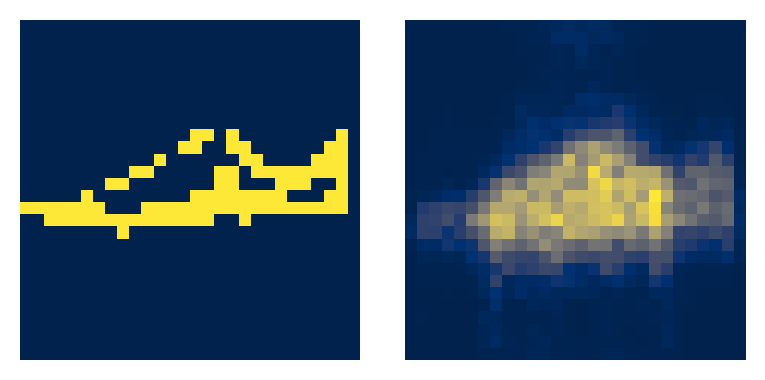

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
params_test = res_vae["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");
plt.tight_layout()

### Hard-EM unamortised

In [129]:
%%time
model_hem = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
config_hem = hlax.unamortised.load_config(config, model_hem)

res_hem = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_hem,
    config_test,
    iwae_bern_delta,
    elbo_bern,
    hlax.unamortised.train_checkpoints
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 17min 24s, sys: 3min 51s, total: 21min 15s
Wall time: 9min 19s


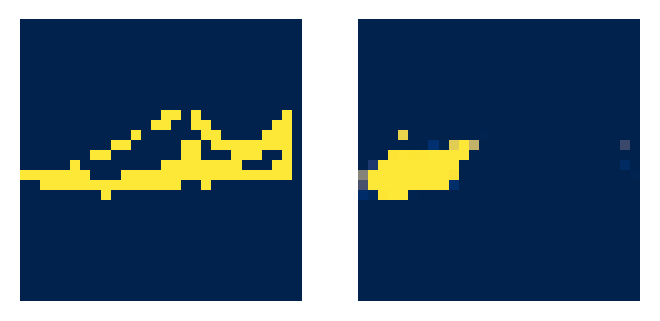

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
params_test = res_hem["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

### Umamortised VAE

In [131]:
%%time
model_uvae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
config_uvae = hlax.unamortised.load_config(config, model_uvae)

res_uvae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_uvae,
    config_test,
    elbo_bern,
    elbo_bern,
    hlax.unamortised.train_checkpoints
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 18min 59s, sys: 3min 54s, total: 22min 53s
Wall time: 10min 38s


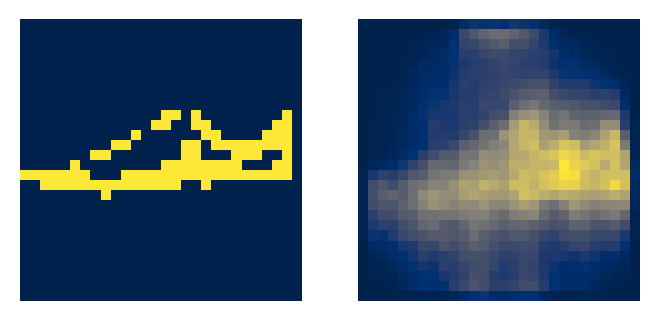

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9

params_test = res_uvae["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

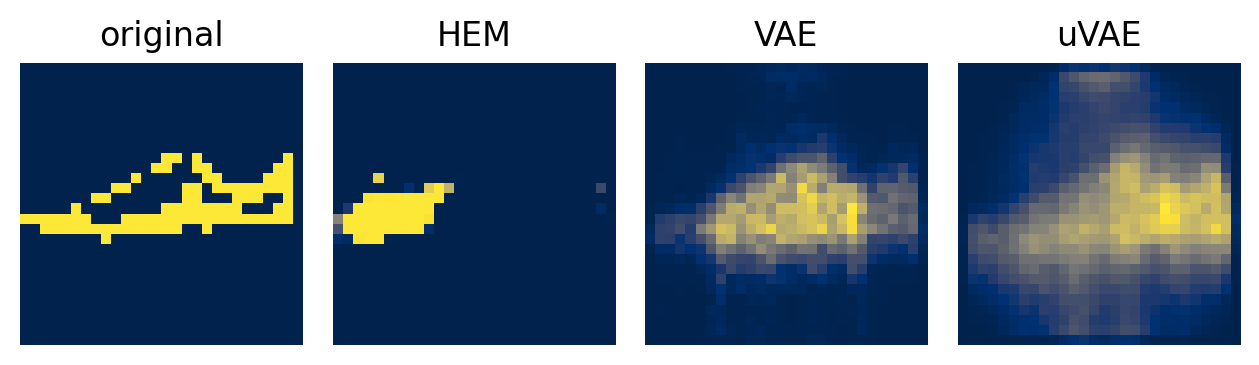

In [133]:
fig, ax = plt.subplots(1, 4)

ix_target = 9
img_truth = X_test[ix_target].reshape(28, 28)
ax[0].imshow(img_truth, cmap="cividis")
ax[0].set_title("original")
ax[0].axis("off")

res_list = [res_hem, res_vae, res_uvae]
labels = ["HEM", "VAE", "uVAE"]
for i, (res, label) in enumerate(zip(res_list, labels)):
    params_test = res["test"]["state"][ix_epoch].params
    img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
    img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)
    ax[i + 1].imshow(img_reconstruct, cmap="cividis")
    ax[i + 1].axis("off")
    ax[i + 1].set_title(label)
plt.tight_layout()

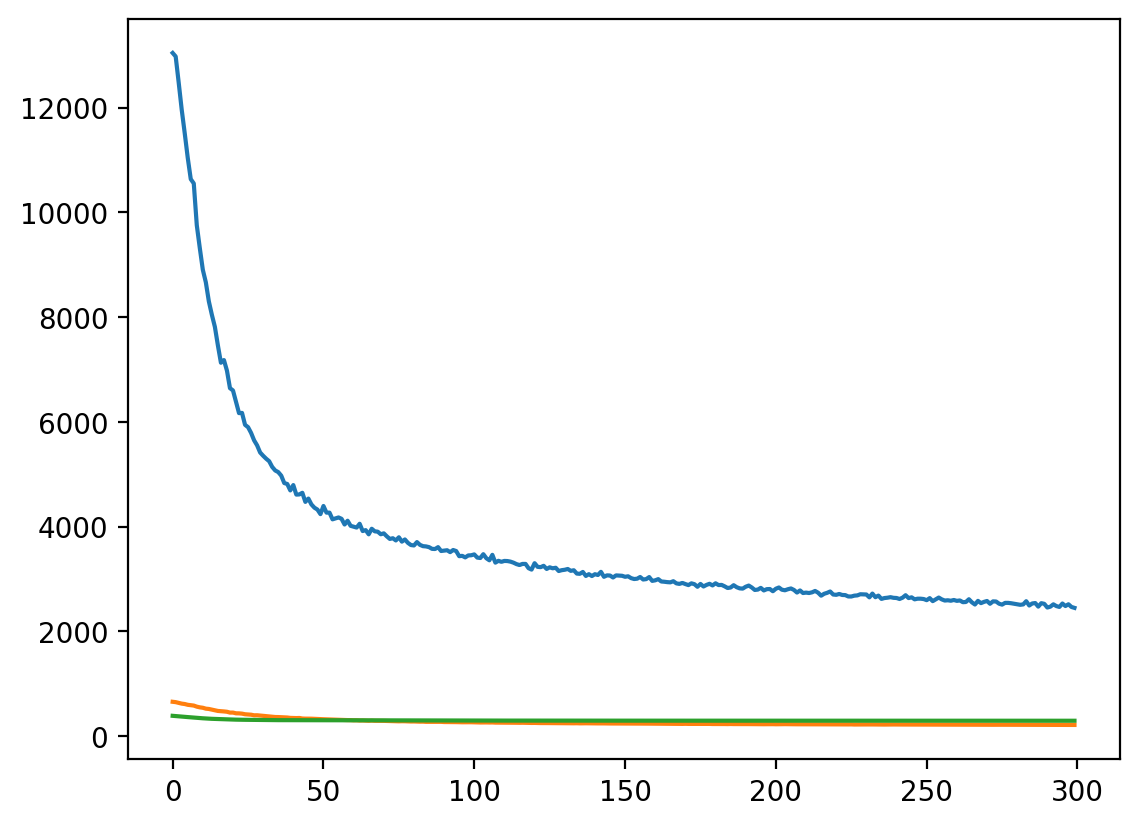

In [134]:
plt.plot(res_hem["test"]["hist_loss"][ix_epoch])
plt.plot(res_vae["test"]["hist_loss"][ix_epoch])
plt.plot(res_uvae["test"]["hist_loss"][ix_epoch])

## Observe training results

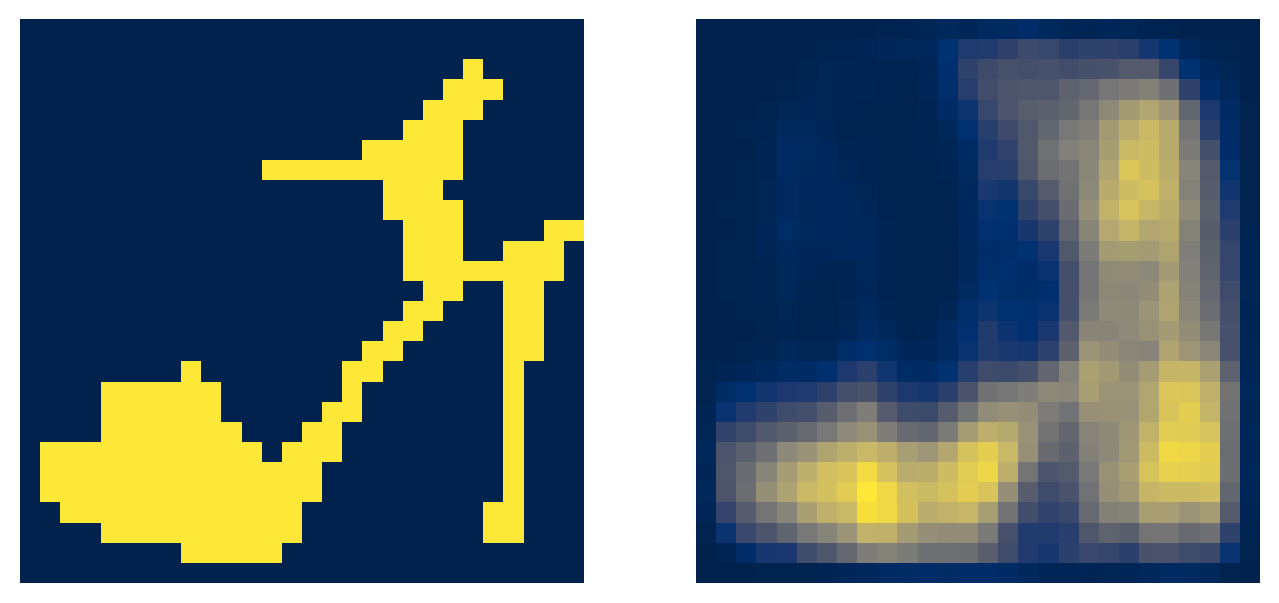

In [135]:
ix_target = 9
res = res_hem
model = model_hem

state_final = res["train"]["state_final"]
params= state_final.params
vals = model.apply(params, X_warmup, key)[1]# [-1][0]

img_reconstruct = vals[ix_target].reshape(28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

In [136]:
from functools import partial
apply_fn = partial(config_test.model.apply, num_samples=10)


device_cpu = jax.devices("cpu")[0]

In [137]:
num_samples = 10
keys_eval = jax.random.split(key, num_samples)
vmap_iwae = jax.vmap(iwae_bern, (0, None, None, None))

res_list = [res_hem, res_vae, res_uvae]
labels = ["HEM", "VAE", "uVAE"]

df_mll = []
elements = list(zip(res_list, labels))
for res, label in tqdm(elements):
    for ix_epoch in res["test"]["state"]:
        
        state_test = res["test"]["state"][ix_epoch]
        params_test = jax.device_put(state_test.params, device_cpu)
        is_mll = vmap_iwae(keys_eval, params_test, apply_fn, X_test)

        entry = {
            "label": label,
            "mll": is_mll.to_py(),
            "epoch": int(ix_epoch.lstrip("e")),
            "time": res["train"]["times"][ix_epoch],
        }

        df_mll.append(entry)
df_mll = pd.DataFrame(df_mll).explode("mll")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:15<00:00, 65.21s/it]


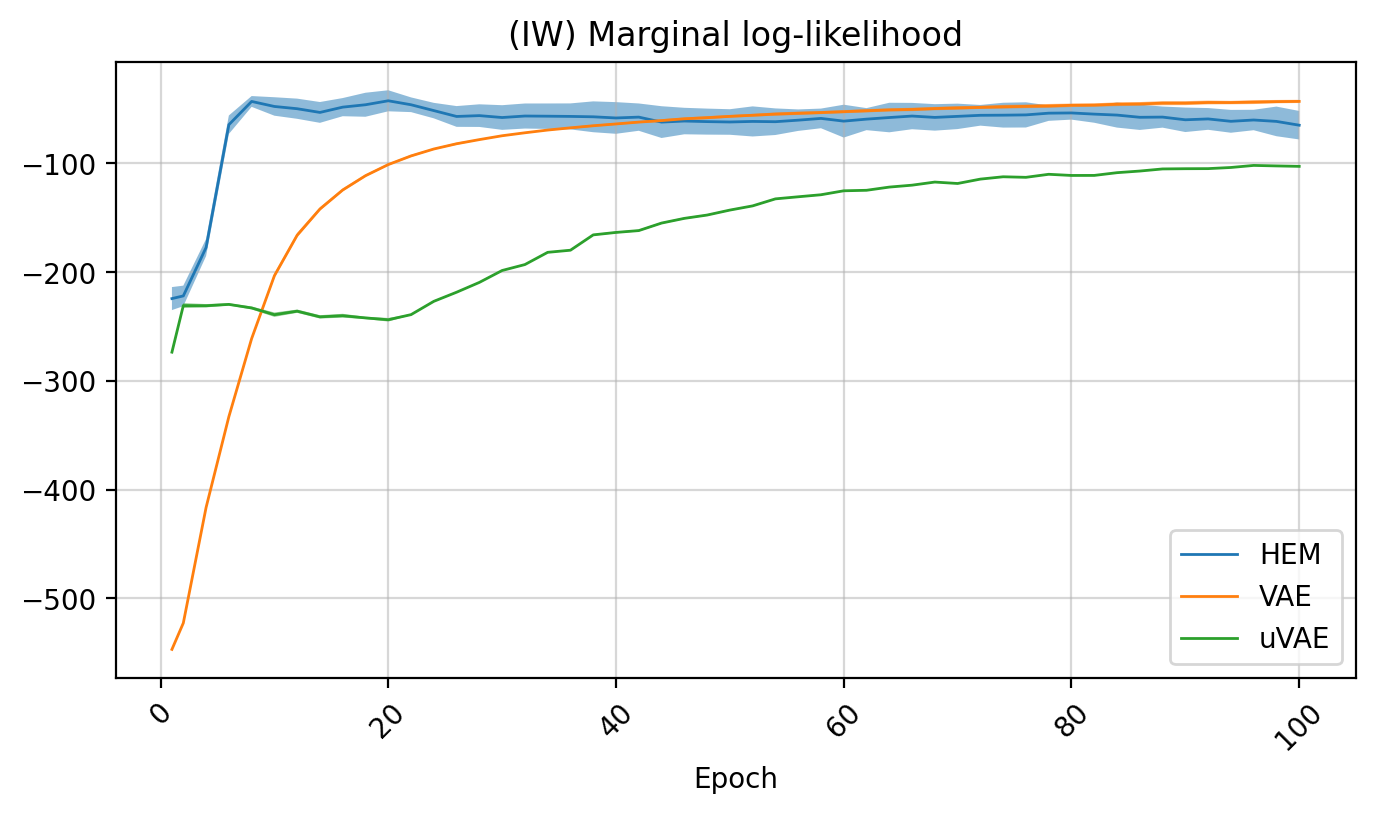

In [138]:
mll_std = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="std")
mll_mean = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="mean")

fig, ax = plt.subplots(figsize=(8, 4))
xvals = mll_mean.index
for col in mll_mean:
    mean = mll_mean[col]
    std = mll_std[col]
    
    plt.fill_between(xvals, mean - 2 * std, mean + 2 * std, alpha=0.5)
    plt.plot(xvals, mean, label=col, linewidth=1)
    
plt.legend()
plt.title("(IW) Marginal log-likelihood")
plt.xlabel("Epoch")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)